<a href="https://colab.research.google.com/github/Shabrinath/langgraph-support-bot/blob/main/langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install langchain langgraph langchain_openai

In [6]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [8]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

# Define a simple state
class TicketState(dict):
    ticket_text: str
    category: str
    reply: str | None

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini")

# --- Nodes ---
def receive_ticket(state: TicketState):
    print("📩 Received ticket:", state["ticket_text"])
    return state

def categorize_ticket_llm(state: TicketState):
    """Ask LLM to classify the ticket."""
    prompt = f"""
    You are a support triage assistant. Categorize the ticket as either:
    - devops
    - billing

    Ticket: {state['ticket_text']}
    Just reply with the category.
    """
    result = llm.invoke(prompt)
    state["category"] = result.content.strip().lower()
    return state

def devops_reply_llm(state: TicketState):
    """If DevOps, generate reply to user."""
    prompt = f"""
    You are a DevOps support engineer. Write a helpful reply to the ticket below.

    Ticket: {state['ticket_text']}
    """
    result = llm.invoke(prompt)
    state["reply"] = result.content
    print("🤖 DevOps Reply:", state["reply"])
    return state

def billing_route(state: TicketState):
    """If Billing, route to human support."""
    print("💰 Routing to Billing team...")
    return state

# --- Build Graph ---
workflow = StateGraph(TicketState)

workflow.add_node("receive_ticket", receive_ticket)
workflow.add_node("categorize_ticket_llm", categorize_ticket_llm)
workflow.add_node("devops_reply_llm", devops_reply_llm)
workflow.add_node("billing_route", billing_route)

workflow.set_entry_point("receive_ticket")

# Flow: receive_ticket -> categorize_ticket_llm
workflow.add_edge("receive_ticket", "categorize_ticket_llm")

# Decision branch
workflow.add_conditional_edges(
    "categorize_ticket_llm",
    lambda state: state["category"],
    {
        "devops": "devops_reply_llm",
        "billing": "billing_route",
    }
)

# Both end after their action
workflow.add_edge("devops_reply_llm", END)
workflow.add_edge("billing_route", END)

# --- Compile ---
app = workflow.compile()

# --- Example run ---
state = {"ticket_text": "My order was incorrectly billed."}
final_state = app.invoke(state)


📩 Received ticket: My order was incorrectly billed.
💰 Routing to Billing team...


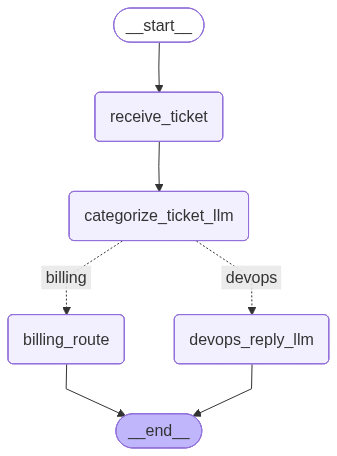

In [9]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)